In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd

from src import data_pipeline, volatility_models, forecast_evaluation

vix_data = data_pipeline.prepare_series()
returns = vix_data.frame['dlog_vix'].dropna()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
garch_fit = volatility_models.fit_garch(returns, distribution='t')
arch_res = garch_fit['result']

cond_vol = arch_res.conditional_volatility / 100.0
phi0 = arch_res.params.get('Const', 0.0) / 100.0
phi1 = arch_res.params.get('ar[1]', 0.0)
mean_hat = phi0 + phi1 * returns.shift(1)

garch_df = pd.DataFrame(
    {
        'mean': mean_hat,
        'variance': cond_vol**2,
    },
    index=returns.index,
).dropna()

garch_df.tail()

,mean,variance
date,,
2025-11-18,-0.004537,0.007910
2025-11-19,-0.004537,0.008639
2025-11-20,-0.004537,0.006975
2025-11-21,-0.004537,0.008098
2025-11-24,-0.004537,0.008727


In [18]:
ewma_var = forecast_evaluation.ewma_variance(returns)
roll_var = forecast_evaluation.rolling_variance(returns)
comparison = pd.concat([garch_df['variance'], ewma_var, roll_var], axis=1).dropna()
comparison.columns = ['garch_var', 'ewma_var', 'roll_var']
comparison.tail()

,garch_var,ewma_var,roll_var
date,,,
2025-11-18,0.007910,0.006585,0.005846
2025-11-19,0.008639,0.006299,0.005463
2025-11-20,0.006975,0.006652,0.005615
2025-11-21,0.008098,0.007118,0.005874
2025-11-24,0.008727,0.006763,0.005901


In [19]:
actual = returns.loc[comparison.index]
zero_mean = pd.Series(0.0, index=actual.index)
scores = {
    'garch_log': forecast_evaluation.log_score(actual, zero_mean, comparison['garch_var']),
    'ewma_log': forecast_evaluation.log_score(actual, zero_mean, comparison['ewma_var']),
    'roll_log': forecast_evaluation.log_score(actual, zero_mean, comparison['roll_var']),
}
scores

{'garch_log': 1.2108410006922925,
 'ewma_log': 1.3046506794431068,
 'roll_log': 1.196624183239949}

In [20]:
pit = pd.Series(forecast_evaluation.pit_values(actual, zero_mean, comparison['garch_var']), index=actual.index)
coverage = forecast_evaluation.coverage_rate(actual, zero_mean, comparison['garch_var'])
pit.describe(), coverage

(count    4.083000e+03
 mean     4.911086e-01
 std      2.609395e-01
 min      6.344001e-07
 25%      2.851824e-01
 50%      4.791475e-01
 75%      6.789507e-01
 max      1.000000e+00
 dtype: float64,
 np.float64(0.9512613274553025))

In [21]:
loss_garch = pd.Series(-(np.log(forecast_evaluation.pit_values(actual, zero_mean, comparison['garch_var']))), index=actual.index)
loss_ewma = pd.Series(-(np.log(forecast_evaluation.pit_values(actual, zero_mean, comparison['ewma_var']))), index=actual.index)
dm_p = forecast_evaluation.diebold_mariano(loss_garch, loss_ewma)
dm_p

6.639400140784346e-10

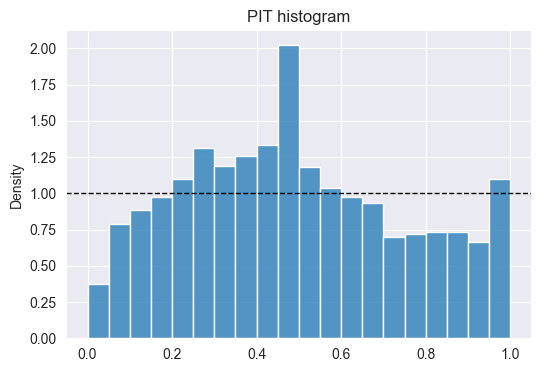

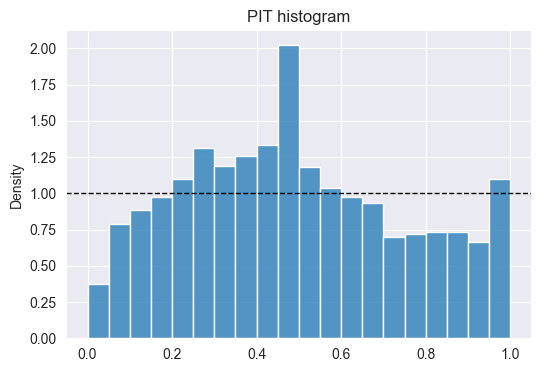

In [22]:
from src import visualization
fig = visualization.plot_pit(pit)
fig